Libraries

In [4]:
import numpy as np
import pandas as pd
from itertools import combinations
from qiskit.quantum_info import SparsePauliOp, Pauli, state_fidelity, Statevector
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from qiskit_aer import AerSimulator
from typing import Callable, Tuple
import pickle
import math
import time
import traceback
import matplotlib.pyplot as plt

Global parameters

In [3]:
N_QUBITS = 5
N = 2**N_QUBITS
TAU = 30e-9              # 30 ns (seconds)
A0 = 2 * np.pi * 15e9       # rad/s
B0 = 2 * np.pi * 11e9       # rad/s
REPS = 1
M = 1
#REPS = 64
#M = int(np.ceil(2000 / REPS))    # -> 32 slices when REPS=64
DELTA_T = TAU / M
ORDER = 2                # Suzuki-Trotter order
RANDOM_STATE = 42
N_SPLITS = 5

# added by Jiri
OPTIMIZATION_LEVEL = 0
SHOTS = 1024
NOISE_MODEL = None

Dataset

In [4]:
dataset_save = "Dataset/Toxicity-13F.csv"
dataset_5F = "Dataset/Toxicity-5F.csv"
dataset_8F = "Dataset/Toxicity-8F.csv"
    
df = pd.read_csv(dataset_save)
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)

df5 = pd.read_csv(dataset_5F)

df8 = pd.read_csv(dataset_8F)



Building model

In [5]:
def s_of_t(t, tau=TAU):
    # s(t) = sin^2( (pi/2) * sin^2(pi t / (2 tau)) )
    inner = np.sin(np.pi * t / (2 * tau)) ** 2
    return np.sin((np.pi / 2) * inner) ** 2

def A_of_t(t): 
    return A0 * (1.0 - s_of_t(t))

def B_of_t(t): 
    return B0 * s_of_t(t)

def build_HD(n):
    #H_D = - sum_i X_i represented as a SparsePauliOp
    labels = []
    coeffs = []
    for i in range(n):
        s = ['I'] * n
        s[i] = 'X'
        labels.append(''.join(s))
        coeffs.append(-1.0)
    pauli_list = [Pauli(label) for label in labels]
    return SparsePauliOp(pauli_list, coeffs)

def build_HD_matrix(n):
    # Single-qubit Pauli-X
    X = np.array([[0, 1],
                  [1, 0]], dtype=complex)
    I = np.eye(2, dtype=complex)

    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n):
        # Start from identity and apply X on qubit i
        ops = []
        for j in range(n):
            ops.append(X if j == i else I)
        # Tensor product (Kronecker product) to get full operator for this i
        H_i = ops[0]
        for op in ops[1:]:
            H_i = np.kron(H_i, op)
        H -= H_i  # sum_i (-X_i)
    return H

def build_HP_from_sample(x_std, Jij):
    # Problem Hamiltonian HP(x) = sum_i hi Z_i + sum_{i<j} Jij Z_i Z_j
    # where hi = x_i and Jij is correlation matrix entries.
    n = len(x_std)
    labels = []
    coeffs = []
    # local fields
    for i in range(n):
        s = ['I'] * n
        s[i] = 'Z'
        labels.append(''.join(s))
        coeffs.append(float(x_std[i]))
    # pairwise ZZ
    for i, j in combinations(range(n), 2):
        s = ['I'] * n
        s[i] = 'Z'
        s[j] = 'Z'
        labels.append(''.join(s))
        coeffs.append(float(Jij[i, j]))
    pauli_list = [Pauli(label) for label in labels]
    return SparsePauliOp(pauli_list, coeffs)

def build_HP_matrix_diagonal(x_std, Jij):
    """
    Build H_P as a dense matrix by computing its diagonal (since H_P is diagonal).
    Returns a (2**n, 2**n) ndarray.

    Conventions:
    - x_std: shape (n,) local fields h_i
    - Jij: (n,n) symmetric coupling matrix with zeros on diagonal
    - Qubit ordering: qubit 0 is the most-significant bit (MSB) in basis index.
    """
    x = np.asarray(x_std).ravel()
    n = x.shape[0]
    dim = 1 << n  # 2**n

    # Precompute z_i for each basis state and each qubit by bit operations
    # We will compute diag[k] = sum_i h_i * z_i(k) + sum_{i<j} Jij[i,j] * z_i(k) * z_j(k)
    # where z_i(k) = +1 if bit i == 0 else -1. With the MSB convention:
    # bit for qubit i is ((k >> (n-1-i)) & 1)
    diag = np.zeros(dim, dtype=float)
    indices = np.arange(dim, dtype=int)

    # Precompute z matrix maybe expensive memory-wise for large n; instead compute per qubit
    # but we can compute z_i for all indices quickly:
    z_bits = np.zeros((n, dim), dtype=int)
    for i in range(n):
        bitpos = n - 1 - i
        z_bits[i] = 1 - 2 * ((indices >> bitpos) & 1)  # +1 or -1

    # local fields contribution
    # diag += sum_i h_i * z_i
    diag += np.dot(x, z_bits)  # shape (dim,)

    # pairwise contribution: sum_{i<j} Jij[i,j] * z_i * z_j
    # We can compute this pairwise loop (n small => cheap)
    for i, j in combinations(range(n), 2):
        if Jij[i, j] == 0:
            continue
        diag += Jij[i, j] * (z_bits[i] * z_bits[j])

    # return full dense matrix (diagonal)
    return np.diag(diag)

def make_evolution_circuit(n_qubits, HP_op_time_dep_fn):
    qc = QuantumCircuit(n_qubits)
    # initial |+>^{n}
    for q in range(n_qubits):
        qc.h(q)

    # Prebuild H_D (Pauli sum op)
    HD_op = build_HD(n_qubits)

    # Append m slices. For slice k (0..m-1) freeze at midpoint t_{k+1/2} = (k+0.5)*dt
    for k in range(M):
        t_mid = (k + 0.5) * DELTA_T
        A = A_of_t(t_mid)
        B = B_of_t(t_mid)
        HP_mid = HP_op_time_dep_fn(k)

        # H_slice = A * HD + B * HP_mid
        H_slice = (A * HD_op) + (B * HP_mid)

        evo_gate = PauliEvolutionGate(H_slice, time=DELTA_T, synthesis=SuzukiTrotter(order=ORDER, reps=REPS))
        qc.append(evo_gate, qc.qubits)

    return qc

def build_circuit_for_sample(x_std, Jij):
    n = len(x_std)
    HP_op = build_HP_from_sample(x_std, Jij)
    qc = make_evolution_circuit(n, lambda k: HP_op)
    return qc

Exact solution

In [6]:
def exact_time_evolution_state(x_std, Jij):
    n = N_QUBITS
    #HD = build_HD(n)
    HD = build_HD_matrix(n)

    def evolve_one_sample(x_sample):
        # x_sample must be 1D length n
        dim = 2 ** n
        psi = np.ones((dim,), dtype=complex) / np.sqrt(dim)
        for k in range(M):
            t_mid = (k + 0.5) * DELTA_T
            A = A_of_t(t_mid)
            B = B_of_t(t_mid)
            #HP = build_HP_from_sample(x_sample, Jij)
            HP = build_HP_matrix_diagonal(x_sample, Jij)
            H_slice = (A * HD) + (B * HP)
            #H_mat = H_slice.to_matrix()
            U = expm(-1j * H_slice * DELTA_T)
            psi = U.dot(psi)
        
        return Statevector(psi)
    psis = []
    for i in range(len(x_std)):
        x_sample = x_std[i]
        psi = evolve_one_sample(x_sample)
        psis.append(psi)

    return psis

def comparison_of_states(psi1, psi2):
    fidelity = state_fidelity(psi1, psi2, validate=True)
    return fidelity

Approximation (using Trotterization)

In [7]:
def make_evolution_for_sample(n_qubits, HP_op_time_dep_fn):
    qc = QuantumCircuit(n_qubits)
    # initial |+>^{n}
    for q in range(n_qubits):
        qc.h(q)

    # Prebuild H_D (Pauli sum op)
    HD_op = build_HD(n_qubits)

    # Append m slices. For slice k (0..m-1) freeze at midpoint t_{k+1/2} = (k+0.5)*dt
    for k in range(M):
        t_mid = (k + 0.5) * DELTA_T
        A = A_of_t(t_mid)
        B = B_of_t(t_mid)
        HP_mid = HP_op_time_dep_fn(k)

        # H_slice = A * HD + B * HP_mid
        H_slice = (A * HD_op) + (B * HP_mid)

        evo_gate = PauliEvolutionGate(H_slice, time=DELTA_T, synthesis=SuzukiTrotter(order=ORDER, reps=REPS))
        qc.append(evo_gate, qc.qubits)
        statevector = Statevector.from_instruction(qc)
        #simulator = AerSimulator(method='DensityMatrix')

    return statevector.data

def build_circuit_for_sample(x_std, Jij):
    n = len(x_std)
    HP_op = build_HP_from_sample(x_std, Jij)
    data = make_evolution_for_sample(n, lambda k: HP_op)
    return data

def evolve_all(x_std, Jij):
    n_samples = len(x_std)
    all_data = []
    for i in range(n_samples):
        x_sample = x_std[i]
        data = build_circuit_for_sample(x_sample, Jij)
        all_data.append(data)
    return all_data



Comparison

In [ ]:
import numpy as np
from qiskit.quantum_info import Operator
from scipy.linalg import expm

X = df5.drop(columns=['Class']).values
y = df5['Class'].values

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

#TAU = 30e-9              # 30 ns (seconds)
#A0 = 2 * np.pi * 15e9       # rad/s
#B0 = 2 * np.pi * 11e9 
TAU = 100
A0 = 2 * np.pi
B0 = 2 * np.pi   
REPS = 50
M = 4

fold_idx = 0 
for train_idx, test_idx in skf.split(X, y): 
    fold_idx += 1 
    Xtrain, Xtest = X[train_idx], X[test_idx] 
    ytrain, ytest = y[train_idx], y[test_idx]

    # preprocessing 
    imputer = SimpleImputer(strategy='median') 
    imputer.fit(Xtrain) 
    Xtrain_im = imputer.transform(Xtrain) 
    Xtest_im = imputer.transform(Xtest) 

    scaler = StandardScaler() 
    scaler.fit(Xtrain_im) 
    Xtrain_std = scaler.transform(Xtrain_im) 
    Xtest_std = scaler.transform(Xtest_im) 

    # Jij computed from training set Pearson correlations, diag set to 0 
    rho = np.corrcoef(Xtrain_std, rowvar=False) 
    np.fill_diagonal(rho, 0.0) 
    Jij = rho.copy()
    # pick one sample
    i = 0
    x_sample = Xtrain_std[i]         # or Xtrain_std[0]
    n = len(x_sample)

    # Build the dense HP diagonal and HD dense used by exact evolution:
    HP_dense = build_HP_matrix_diagonal(x_sample, Jij)     # (2**n,2**n)
    HD_dense = build_HD_matrix(n)

    # Compute dense H_slice used in exact method (for k=0 slice)
    t_mid = (0 + 0.5) * DELTA_T
    A = A_of_t(t_mid)
    B = B_of_t(t_mid)
    H_slice_dense = (A * HD_dense) + (B * HP_dense)

    # Now build the SparsePauliOp version used in circuit path:
    HP_sparse = build_HP_from_sample(x_sample, Jij)   # SparsePauliOp
    HD_sparse = build_HD(n)                           # SparsePauliOp

    # Convert sparse ops to dense matrices and compare
    HP_sparse_mat = HP_sparse.to_matrix()             # dense
    HD_sparse_mat = HD_sparse.to_matrix()

    print("|| HP_sparse - HP_dense ||_inf =", np.max(np.abs(HP_sparse_mat - HP_dense)))
    print("|| HD_sparse - HD_dense ||_inf =", np.max(np.abs(HD_sparse_mat - HD_dense)))

    # build H_slice from SparsePauliOp (matrix)
    H_slice_from_sparse = A * HD_sparse_mat + B * HP_sparse_mat

    print("|| H_slice_dense - H_slice_from_sparse ||_inf =", np.max(np.abs(H_slice_dense - H_slice_from_sparse)))

    # Build the PauliEvolutionGate object (same as in your circuit)
    H_slice_opflow = (A * build_HD(n)) + (B * build_HP_from_sample(x_sample, Jij))
    evo_gate = PauliEvolutionGate(H_slice_opflow, time=DELTA_T,
                                synthesis=SuzukiTrotter(order=ORDER, reps=REPS))

    # Convert evo_gate to an Operator (unitary) by appending to 1-qubit-per-system circuit
    from qiskit import QuantumCircuit
    qc_test = QuantumCircuit(n)
    qc_test.append(evo_gate, list(range(n)))
    U_trot = Operator(qc_test).data           # (2**n,2**n) unitary from synthesized circuit

    # exact unitary:
    U_exact = expm(-1j * H_slice_dense * DELTA_T)

    print("|| U_trot - U_exact ||_inf =", np.max(np.abs(U_trot - U_exact)))
    print("|| U_trot - U_exact ||_2  =", np.linalg.norm(U_trot - U_exact))

    H_slice_opflow = (A * build_HD(n)) + (B * build_HP_from_sample(x_sample, Jij))
    evo_gate = PauliEvolutionGate(H_slice_opflow, time=DELTA_T,
                                synthesis=SuzukiTrotter(order=ORDER, reps=REPS))
    qc_test = QuantumCircuit(n)
    qc_test.append(evo_gate, list(range(n)))

    # 2) Transpile to basis gates to force use of the Suzuki-Trotter decomposition
    #    Choose basis_gates typical for backends, e.g. ['u3','cx'] or ['rz','sx','cx'] depending on Qiskit
    from qiskit import transpile
    transpiled = transpile(qc_test, basis_gates=['u3','cx'], optimization_level=0)

    # 3) Get unitary of the transpiled circuit (this reflects the trotter decomposition implemented)
    U_decomposed = Operator(transpiled).data

    # 4) The exact exponential
    U_exact = expm(-1j * H_slice_dense * DELTA_T)

    print("transpiled circuit depth:", transpiled.depth())
    print("|| U_decomposed - U_exact ||_inf =", np.max(np.abs(U_decomposed - U_exact)))
    print("|| U_decomposed - U_exact ||_2  =", np.linalg.norm(U_decomposed - U_exact))


X_std, J_ij prep

In [9]:
X = df5.drop(columns=['Class']).values
y = df5['Class'].values

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

fold_idx = 0 
for train_idx, test_idx in skf.split(X, y): 
    fold_idx += 1 
    Xtrain, Xtest = X[train_idx], X[test_idx] 
    ytrain, ytest = y[train_idx], y[test_idx]

print(Xtrain.shape, Xtest.shape)


# preprocessing 
imputer = SimpleImputer(strategy='median') 
imputer.fit(Xtrain) 
Xtrain_im = imputer.transform(Xtrain) 
Xtest_im = imputer.transform(Xtest) 

scaler = StandardScaler() 
scaler.fit(Xtrain_im) 
Xtrain_std = scaler.transform(Xtrain_im) 
Xtest_std = scaler.transform(Xtest_im)

print(Xtrain_std.shape, Xtest_std.shape)

rho = np.corrcoef(Xtrain_std, rowvar=False) 
np.fill_diagonal(rho, 0.0) 
Jij = rho.copy()

print(rho)
print(Jij)

(137, 5) (34, 5)
(137, 5) (34, 5)
[[ 0.         -0.15074187 -0.12788001  0.70433879  0.46975849]
 [-0.15074187  0.          0.92722492 -0.27701518 -0.12379141]
 [-0.12788001  0.92722492  0.         -0.27747499 -0.13856558]
 [ 0.70433879 -0.27701518 -0.27747499  0.          0.61105101]
 [ 0.46975849 -0.12379141 -0.13856558  0.61105101  0.        ]]
[[ 0.         -0.15074187 -0.12788001  0.70433879  0.46975849]
 [-0.15074187  0.          0.92722492 -0.27701518 -0.12379141]
 [-0.12788001  0.92722492  0.         -0.27747499 -0.13856558]
 [ 0.70433879 -0.27701518 -0.27747499  0.          0.61105101]
 [ 0.46975849 -0.12379141 -0.13856558  0.61105101  0.        ]]


Reference with rk4

In [ ]:
def rk4_evolve(H_func: Callable[[float], np.ndarray], tau: float, Nsteps: int, reunitarize: bool = True) -> np.ndarray:
    dt = tau / float(Nsteps)
    H0 = H_func(0.0)
    N = H0.shape[0]
    U = np.eye(N, dtype=complex)

    t = 0.0
    for step in range(Nsteps):
        # classic RK4 on matrix ODE: dU/dt = -i H(t) U(t)
        H1 = H_func(t)
        k1 = -1j * (H1 @ U)

        H2 = H_func(t + 0.5 * dt)
        k2 = -1j * (H2 @ (U + 0.5 * dt * k1))

        k3 = -1j * (H2 @ (U + 0.5 * dt * k2))  # use H(t+dt/2) for k3 as well

        H4 = H_func(t + dt)
        k4 = -1j * (H4 @ (U + dt * k3))

        U = U + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        t += dt

    if reunitarize:
        # Reunitarize using SVD: U -> (U U^†)^{-1/2} U ≈ U_svd = Uu @ Vh
        # Simpler robust approach: polar via SVD -> U_unitary = u @ vh
        u, s, vh = np.linalg.svd(U)
        U = u @ vh

    return U

def H_model(t: float) -> np.ndarray:
    s = np.sin(np.pi*np.sin(np.pi*t / (2* TAU)) / 2) ** 2
    A = A0 * (1.0 - s)
    B = B0 * s
    HD = build_HD_matrix(N_QUBITS)
    HP = build_HP_matrix_diagonal(x_sample, Jij)
    H = A * HD + B * HP
    return H

def operator_norm(U1: np.ndarray, U2: np.ndarray) -> float:
    return np.linalg.norm(U1 - U2, 2)

def select_Nref(H_func: Callable[[float], np.ndarray], tau: float,
                N0: int = 10000, tol: float = 1e-9, max_N: int = 200_000,
                reunitarize: bool = True, verbose: bool = True
               ) -> Tuple[int, np.ndarray]:
    
    N = N0
    U_prev = rk4_evolve(H_func, tau, N, reunitarize=reunitarize)
    if verbose:
        print(f"[select_Nref] start N={N}")
    while True:
        N2 = N * 2
        if N2 > max_N:
            print(f"[select_Nref] reached max_N={max_N}, returning N={N2}")
            U_curr = rk4_evolve(H_func, tau, N2, reunitarize=reunitarize)
            return N2, U_curr

        U_curr = rk4_evolve(H_func, tau, N2, reunitarize=reunitarize)
        err = operator_norm(U_curr, U_prev)
        if verbose:
            print(f"[select_Nref] N={N:8d} -> 2N={N2:8d}, ||U(2N)-U(N)|| = {err:.3e}")

        # For RK4, local error ~ N^{-4}. Using Richardson, we expect
        # U_true - U_N ≈ C*N^{-4} => U_2N - U_N ≈ C*(2^{-4}-1)*N^{-4}.
        # So estimate C from observed delta and estimate remaining error at 2N:
        if err == 0:
            # converged to numerical roundoff
            if verbose:
                print("[select_Nref] error is zero (machine precision).")
            return N2, U_curr

        # Estimate constant C_est and estimated residual at 2N:
        factor = (2**(-4) - 1.0)  # = -15/16
        C_est = err / abs(factor) / (N**(-4))
        # estimated error of U_curr relative to true U ≈ C_est * (N2^{-4})
        est_err_Ucurr = C_est * (N2**(-4))
        if verbose:
            print(f"  estimated C ~ {C_est:.3e}, estimated ||U_true - U(2N)|| ~ {est_err_Ucurr:.3e}")

        if est_err_Ucurr < tol:
            if verbose:
                print(f"[select_Nref] target tol={tol} reached with N_ref={N2}")
            return N2, U_curr

        # otherwise keep going: shift window and continue
        N = N2
        U_prev = U_curr
    


if __name__ == "__main__":    
    # Build a very accurate reference using many RK4 steps
    #N_ref = 20000
    #print(f"Computing U_ref with RK4, Nsteps={N_ref} ...")
    #U_ref = rk4_evolve(H_model, TAU, N_ref, reunitarize=True)

    #N_test = 19900
    #U_test = rk4_evolve(H_model, TAU, N_test, reunitarize=True)
    #err = np.linalg.norm(U_ref - U_test, ord=2)
    #print(err)

    N_ref, U_ref = select_Nref(H_model, TAU, N0=10000, tol=1e-9, max_N=200000, verbose=True)
    with open("U_ref.pkl", "wb") as f:
        pickle.dump({"U_ref": U_ref, "N_ref": N_ref, "TAU": TAU}, f)

[select_Nref] start N=10000
[select_Nref] N=   10000 -> 2N=   20000, ||U(2N)-U(N)|| = 2.000e+00
  estimated C ~ 2.133e+16, estimated ||U_true - U(2N)|| ~ 1.333e-01
[select_Nref] N=   20000 -> 2N=   40000, ||U(2N)-U(N)|| = 1.966e+00
  estimated C ~ 3.356e+17, estimated ||U_true - U(2N)|| ~ 1.311e-01
[select_Nref] N=   40000 -> 2N=   80000, ||U(2N)-U(N)|| = 1.981e+00
  estimated C ~ 5.409e+18, estimated ||U_true - U(2N)|| ~ 1.321e-01
[select_Nref] N=   80000 -> 2N=  160000, ||U(2N)-U(N)|| = 2.663e-01
  estimated C ~ 1.164e+19, estimated ||U_true - U(2N)|| ~ 1.776e-02
[select_Nref] reached max_N=200000, returning N=320000
320000


In [ ]:
psi_0 = np.ones((2**N_QUBITS,), dtype=complex) / np.sqrt(2**N_QUBITS)
psi_rk4 = Statevector(U_ref @ psi_0)


def evolve_one_sample(x_sample):
    # x_sample must be 1D length n
    HD = build_HD_matrix(N_QUBITS)
    HP = build_HP_matrix_diagonal(x_sample, Jij)
    dim = 2 ** N_QUBITS
    psi = np.ones((dim,), dtype=complex) / np.sqrt(dim)
    for k in range(M):
        t_mid = (k + 0.5) * DELTA_T
        A = A_of_t(t_mid)
        B = B_of_t(t_mid)
        #HP = build_HP_from_sample(x_sample, Jij)
        HP = build_HP_matrix_diagonal(x_sample, Jij)
        H_slice = (A * HD) + (B * HP)
        #H_mat = H_slice.to_matrix()
        U = expm(-1j * H_slice * DELTA_T)
        psi = U.dot(psi)
    
    return Statevector(psi)

psi_exact = evolve_one_sample(x_sample)
print("Fidelity RK4 vs exact:", state_fidelity(psi_rk4, psi_exact))

Fidelity RK4 vs exact: 0.0761592420957836


How fidelity depends on M

[1/1000] M=1, fidelity=0.079142963043, elapsed=0.0s
[51/1000] M=51, fidelity=0.871069217028, elapsed=0.6s
[101/1000] M=101, fidelity=0.911089371845, elapsed=2.0s
[151/1000] M=151, fidelity=0.971160027477, elapsed=4.4s
[201/1000] M=201, fidelity=0.985982326901, elapsed=7.7s
[251/1000] M=251, fidelity=0.961969460450, elapsed=11.8s
[301/1000] M=301, fidelity=0.992688866918, elapsed=16.8s
[351/1000] M=351, fidelity=0.990198785595, elapsed=23.0s
[401/1000] M=401, fidelity=0.964694454846, elapsed=29.9s
[451/1000] M=451, fidelity=0.987782069423, elapsed=37.6s
[501/1000] M=501, fidelity=0.976383049520, elapsed=46.5s
[551/1000] M=551, fidelity=0.994438075626, elapsed=56.2s
[601/1000] M=601, fidelity=0.998080369349, elapsed=66.7s
[651/1000] M=651, fidelity=0.997995950367, elapsed=80.4s
[701/1000] M=701, fidelity=0.996637744014, elapsed=94.7s
[750/1000] M=750, fidelity=0.996326018470, elapsed=109.9s
[751/1000] M=751, fidelity=0.996306486583, elapsed=110.2s
[801/1000] M=801, fidelity=0.96441128561

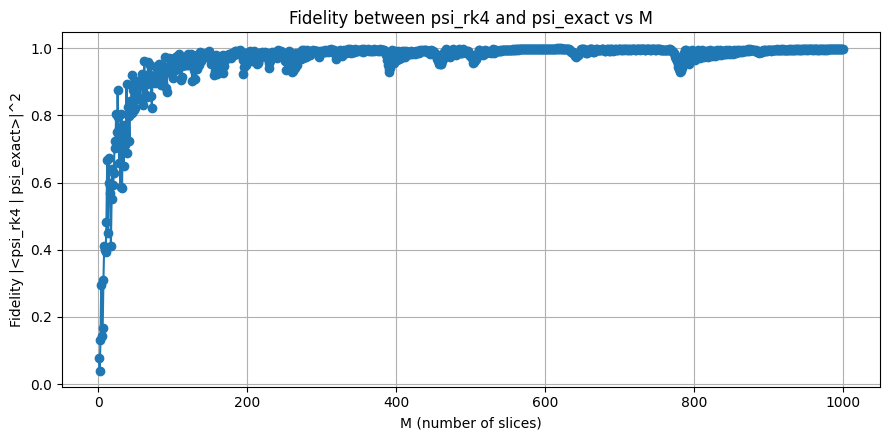

In [ ]:
def to_numpy_state(psi_obj):
    """Return 1D complex numpy array for a Statevector-like object or numpy array."""
    if hasattr(psi_obj, "data"):              # qiskit Statevector
        return np.asarray(psi_obj.data, dtype=complex).ravel()
    psi = np.asarray(psi_obj, dtype=complex).ravel()
    if psi.ndim == 1:
        return psi
    raise ValueError("Could not convert psi object to 1D complex numpy array.")

# Ensure required globals exist
required = ["build_HD_matrix", "build_HP_matrix_diagonal", "A_of_t", "B_of_t",
            "TAU", "N_QUBITS", "x_sample", "Jij", "psi_rk4"]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError("Missing required names in globals: " + ", ".join(missing) +
                    "\nPlease define them (as in your previous cells) before running this cell.")

psi_rk4_np = to_numpy_state(globals()["psi_rk4"])

def evolve_one_sample_numpy(x_sample, M):
    """
    Evolve initial equal-superposition psi for M slices using
    midpoint matrix exponential per slice:
      psi_{n+1} = exp(-i * H(t_mid) * dt) @ psi_n
    Returns psi as 1D complex numpy array.
    """
    Nq = int(globals()["N_QUBITS"])
    HD = globals()["build_HD_matrix"](Nq)
    dim = 2 ** Nq
    psi = np.ones((dim,), dtype=complex) / math.sqrt(dim)
    TAU_local = float(globals()["TAU"])
    dt = TAU_local / float(M)
    for k in range(M):
        t_mid = (k + 0.5) * dt
        A = globals()["A_of_t"](t_mid)
        B = globals()["B_of_t"](t_mid)
        HP = globals()["build_HP_matrix_diagonal"](x_sample, globals()["Jij"])
        H_slice = (A * HD) + (B * HP)
        if not np.isfinite(H_slice).all():
            raise RuntimeError(f"H_slice non-finite at M={M}, step={k}, t_mid={t_mid}")
        U = expm(-1j * H_slice * dt)
        psi = U.dot(psi)
    return psi

# Loop M = 1..1000
M_values = np.arange(1, 1001, dtype=int)
fidelities = np.empty_like(M_values, dtype=float)

start_time = time.time()
last_report_time = start_time
for i, M in enumerate(M_values):
    try:
        psi_exact = evolve_one_sample_numpy(globals()["x_sample"], M)
    except Exception as e:
        tb = traceback.format_exc()
        raise RuntimeError(f"Error computing psi_exact for M={M}:\n{e}\nTraceback:\n{tb}")
    psi_exact_np = np.asarray(psi_exact, dtype=complex).ravel()
    if psi_exact_np.shape != psi_rk4_np.shape:
        raise ValueError(f"Shape mismatch: psi_rk4 {psi_rk4_np.shape} vs psi_exact {psi_exact_np.shape} at M={M}")
    overlap = np.vdot(psi_rk4_np, psi_exact_np)
    fidelities[i] = np.abs(overlap)**2

    # progress every 50 iterations or every 15s
    now = time.time()
    if (i % 50 == 0) or (now - last_report_time > 15):
        elapsed = now - start_time
        print(f"[{i+1}/{len(M_values)}] M={M}, fidelity={fidelities[i]:.12f}, elapsed={elapsed:.1f}s")
        last_report_time = now

total_time = time.time() - start_time
print(f"Finished computing fidelities for M=1..1000 in {total_time:.1f}s")

# Save results
np.savez_compressed("fidelities_vs_M.npz", M_values=M_values, fidelities=fidelities, TAU=TAU, N_QUBITS=N_QUBITS)
import csv
with open("fidelities_vs_M.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["M", "fidelity"])
    for M, fid in zip(M_values, fidelities):
        writer.writerow([int(M), float(fid)])
print("Saved 'fidelities_vs_M.npz' and 'fidelities_vs_M.csv'.")

# Plot
plt.figure(figsize=(9,4.5))
plt.plot(M_values, fidelities, marker='o', linestyle='-')
plt.xlabel("M (number of slices)")
plt.ylabel("Fidelity |<psi_rk4 | psi_exact>|^2")
plt.title("Fidelity between psi_rk4 and psi_exact vs M")
plt.grid(True)
plt.tight_layout()
plt.show()
